<a href="https://colab.research.google.com/github/esgiraldop/machine-learning/blob/master/Tarea5/Tarea5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#To mount drive for workspace. 
from google.colab import drive

#This will prompt for authorization.
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
# installing deap for evolutionary algorithms
pip install deap

In [3]:
!ls "/content/drive/My Drive/CursoMLAvanzado/Estudiantes/Luis-Vesga-Erick-Giraldo/Tarea 5"
%cd /content/drive/My Drive/Subsistemas/hidrodinamica/2019/paperDrag

feature_selection_ga.py  __pycache__	 Tarea5.ipynb
fitness_function.py	 Tarea5-1.ipynb
/content/drive/My Drive/Subsistemas/hidrodinamica/2019/paperDrag


In [4]:
"""Objective: To apply filter selection with a genetic algorithm in a wrap scheme
    with random forest for regression. The fitness function is the accuracy of the
    random forest algorithm
"""
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, classification_report

#from feature_selection_ga import FeatureSelectionGA

"""COLUM NAMES
1. Vendor name: 30 
      (adviser, amdahl,apollo, basf, bti, burroughs, c.r.d, cambex, cdc, dec, 
       dg, formation, four-phase, gould, honeywell, hp, ibm, ipl, magnuson, 
       microdata, nas, ncr, nixdorf, perkin-elmer, prime, siemens, sperry, 
       sratus, wang)
2. Model Name: many unique symbols
3. MYCT: Machine cycle time [nanoseconds]
4. MMIN: Minimum main memory [kilobytes]
5. MMAX: Maximum main memory [kilobytes]
6. CACH: Cache memory [kilobytes]
7. CHMIN: minimum channels [units]
8. CHMAX: maximum channels [units]
9. PRP: published relative performance
10. ERP: estimated relative performance from the original article"""

'COLUM NAMES\n1. Vendor name: 30 \n      (adviser, amdahl,apollo, basf, bti, burroughs, c.r.d, cambex, cdc, dec, \n       dg, formation, four-phase, gould, honeywell, hp, ibm, ipl, magnuson, \n       microdata, nas, ncr, nixdorf, perkin-elmer, prime, siemens, sperry, \n       sratus, wang)\n2. Model Name: many unique symbols\n3. MYCT: Machine cycle time [nanoseconds]\n4. MMIN: Minimum main memory [kilobytes]\n5. MMAX: Maximum main memory [kilobytes]\n6. CACH: Cache memory [kilobytes]\n7. CHMIN: minimum channels [units]\n8. CHMAX: maximum channels [units]\n9. PRP: published relative performance\n10. ERP: estimated relative performance from the original article'

# FeatureSelectionGA

In [0]:
from deap import base, creator
import random
import numpy as np
from deap import tools
#import fitness_function as ff


class FeatureSelectionGA:
    """
        FeaturesSelectionGA
        This class uses Genetic Algorithm to find out the best features for an input model
        using Distributed Evolutionary Algorithms in Python(DEAP) package. Default toolbox is
        used for GA but it can be changed accordingly.
    
    """
    def __init__(self,model,x,y,cv_split=5,verbose=0):
        """
            Parameters
            -----------
            model : scikit-learn supported model, 
                x :  {array-like}, shape = [n_samples, n_features]
                     Training vectors, where n_samples is the number of samples 
                     and n_features is the number of features.
 
                y  : {array-like}, shape = [n_samples]
                     Target Values
            cv_split: int
                     Number of splits for cross_validation to calculate fitness.
            
            verbose: 0 or 1
        """
        self.model =  model
        self.n_features = x.shape[1]
        self.toolbox = None
        self.creator = self._create()
        self.cv_split = cv_split
        self.x = x
        self.y = y
        self.verbose = verbose
        if self.verbose==1:
            print("Model {} will select best features among {} features using cv_split :{}.".format(model,x.shape[1],cv_split))
            print("Shape od train_x: {} and target: {}".format(x.shape,y.shape))
        self.final_fitness = []
        self.fitness_in_generation = {}
        self.best_ind = None
    
    def evaluate(self,individual):
        fit_obj = FitenessFunction(self.cv_split)
        np_ind = np.asarray(individual)
        if np.sum(np_ind) == 0:
            fitness = 0.0
        else:
            feature_idx = np.where(np_ind==1)[0]
            fitness = fit_obj.calculate_fitness(self.model,self.x[:,feature_idx],self.y) # Evaluating fitness for each individual
        
        if self.verbose == 1:
            print("Individual: {}  Fitness_score: {} ".format(individual,fitness))
            
        return fitness,
    
    
    def _create(self):
        creator.create("FeatureSelect", base.Fitness, weights=(1.0,))  # The fitness function is intended to be maximized
        creator.create("Individual", list, fitness=creator.FeatureSelect)
        return creator
    
    def create_toolbox(self):
        """ 
            Custom creation of toolbox.
            Parameters
            -----------
                self
            Returns
            --------
                Initialized toolbox
        """
        
        self._init_toolbox()
        return self.toolbox
        
    def register_toolbox(self,toolbox):
        """ 
            Register custom created toolbox. Evalute function will be registerd
            in this method.
            Parameters
            -----------
                Registered toolbox with crossover,mutate,select tools except evaluate
            Returns
            --------
                self
        """
        toolbox.register("evaluate", self.evaluate)
        self.toolbox = toolbox
     
    
    def _init_toolbox(self):
        toolbox = base.Toolbox() # toolbox store evolutionary operators, and a virtual fitness class used as base class, for the fitness member of any individual
        toolbox.register("attr_bool", random.randint, 0, 1)
        # Structure initializers
        toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, self.n_features)
        toolbox.register("population", tools.initRepeat, list, toolbox.individual)
        return toolbox
        
        
    def _default_toolbox(self):
        toolbox = self._init_toolbox()
        # tools contain the operators for evolutionary algorithm for mating, mutating and selecting individuals
        toolbox.register("mate", tools.cxTwoPoint)  # cxTwoPoint is an operator for mating. The two individuals are modified in place and both keep their original length. This function uses the randint() function from the Python base random module.
        toolbox.register("mutate", tools.mutFlipBit, indpb=0.1) # mutFlipBit is an operator for mutating. Flip the value of the attributes of the input individual and return the mutant. This mutation is usually applied on boolean individuals. The indpb argument is the probability of each attribute to be flipped
        toolbox.register("select", tools.selTournament, tournsize=3) # selTournament is an operator for selecting. Select the best individual among tournsize randomly chosen individuals, k times. The list returned contains references to the input individuals.
        toolbox.register("evaluate", self.evaluate) #Evaluating fitness according to the fitness function
        return toolbox
    
    def get_final_scores(self,pop,fits):
        self.final_fitness = list(zip(pop,fits))
        
    
        
    def generate(self,n_pop,cxpb = 0.5,mutxpb = 0.2,ngen=5,set_toolbox = False):

        """ 
            Generate evolved population
            Parameters
            -----------
                n_pop : {int}
                        population size
                cxpb  : {float}
                        crossover probablity
                mutxpb: {float}
                        mutation probablity
                n_gen : {int}
                        number of generations
                set_toolbox : {boolean}
                              If True then you have to create custom toolbox before calling 
                              method. If False use default toolbox.
            Returns
            --------
                Fittest population
        """
        
        
        
        if self.verbose==1:
            print("Population: {}, crossover_probablity: {}, mutation_probablity: {}, total generations: {}".format(n_pop,cxpb,mutxpb,ngen))
        
        if not set_toolbox:
            self.toolbox = self._default_toolbox()
        else:
            raise Exception("Please create a toolbox.Use create_toolbox to create and register_toolbox to register. Else set set_toolbox = False to use defualt toolbox")
        pop = self.toolbox.population(n_pop)
        CXPB, MUTPB, NGEN = cxpb,mutxpb,ngen

        # Evaluate the entire population
        print("EVOLVING.......")
        fitnesses = list(map(self.toolbox.evaluate, pop))   # listing the fitness for each individual of the population
        
        for ind, fit in zip(pop, fitnesses): 
            ind.fitness.values = fit

        for g in range(NGEN):  # Recall NGEN is an int representing the number of generations
            print("-- GENERATION {} --".format(g+1))
            offspring = self.toolbox.select(pop, len(pop))  # appliying the tournament for selecting the offsprings
            self.fitness_in_generation[str(g+1)] = max([ind.fitness.values[0] for ind in pop])
            # Clone the selected individuals
            offspring = list(map(self.toolbox.clone, offspring))

            # Apply crossover and mutation on the offspring
            for child1, child2 in zip(offspring[::2], offspring[1::2]):
                if random.random() < CXPB:
                    self.toolbox.mate(child1, child2)
                    del child1.fitness.values
                    del child2.fitness.values

            for mutant in offspring:
                if random.random() < MUTPB:
                    self.toolbox.mutate(mutant)
                    del mutant.fitness.values

            # Evaluate the individuals with an invalid fitness
            weak_ind = [ind for ind in offspring if not ind.fitness.valid]
            fitnesses = list(map(self.toolbox.evaluate, weak_ind))
            for ind, fit in zip(weak_ind, fitnesses):
                ind.fitness.values = fit
            print("Evaluated %i individuals" % len(weak_ind))

            # The population is entirely replaced by the offspring
            pop[:] = offspring
            a=1
                    # Gather all the fitnesses in one list and print the stats
        fits = [ind.fitness.values[0] for ind in pop]
        length = len(pop)
        mean = sum(fits) / length
        sum2 = sum(x*x for x in fits)
        std = abs(sum2 / length - mean**2)**0.5
        if self.verbose==1:
            print("  Min %s" % min(fits))
            print("  Max %s" % max(fits))
            print("  Avg %s" % mean)
            print("  Std %s" % std)
    
        print("-- Only the fittest survives --")

        self.best_ind = tools.selBest(pop, 1)[0]
        print("Best individual is %s, %s" % (self.best_ind, self.best_ind.fitness.values))
        self.get_final_scores(pop,fits)
        
        return pop, self.fitness_in_generation, np.array(self.best_ind)

#FitenessFunction

In [0]:
from sklearn.model_selection import StratifiedKFold
import numpy as np
from sklearn.metrics import f1_score

class FitenessFunction:
    
    def __init__(self,n_splits = 5,*args,**kwargs):
        """
            Parameters
            -----------
            n_splits :int, 
                Number of splits for cv
            
            verbose: 0 or 1
        """
        self.n_splits = n_splits
        

    def calculate_fitness(self,model,x,y):
        cv_set = np.repeat(-1.,x.shape[0])
        skf = StratifiedKFold(n_splits = self.n_splits)
        for train_index,test_index in skf.split(x,y):
            x_train,x_test = x[train_index],x[test_index]
            y_train,y_test = y[train_index],y[test_index]
            if x_train.shape[0] != y_train.shape[0]:
                raise Exception()
            model.fit(x_train,y_train)
            predicted_y = model.predict(x_test)
            cv_set[test_index] = predicted_y
            
        return f1_score(y,cv_set, average='micro')

# Main

In [12]:
# using the same data for tarea 2
path_to_datos = '/content/drive/My Drive/CursoMLAvanzado/Estudiantes/Luis-Vesga-Erick-Giraldo/Tarea 2/machine.csv';

cpuData = pd.read_csv(path_to_datos, header = None, sep = ',', 
                         names = ['vendorName','modelName','MYCT',
                                  'MMIN','MMAX','CACH','CHMIN','CHMAX','PRP',
                                  'ERP'])
cpuData.info()
cpuData.describe(include='O')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209 entries, 0 to 208
Data columns (total 10 columns):
vendorName    209 non-null object
modelName     209 non-null object
MYCT          209 non-null int64
MMIN          209 non-null int64
MMAX          209 non-null int64
CACH          209 non-null int64
CHMIN         209 non-null int64
CHMAX         209 non-null int64
PRP           209 non-null int64
ERP           209 non-null int64
dtypes: int64(8), object(2)
memory usage: 16.5+ KB


,vendorName,modelName
count,209,209
unique,30,209
top,ibm,3230
freq,32,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209 entries, 0 to 208
Data columns (total 10 columns):
vendorName    209 non-null object
modelName     209 non-null object
MYCT          209 non-null int64
MMIN          209 non-null int64
MMAX          209 non-null int64
CACH          209 non-null int64
CHMIN         209 non-null int64
CHMAX         209 non-null int64
PRP           209 non-null int64
ERP           209 non-null int64
dtypes: int64(8), object(2)
memory usage: 16.5+ KB


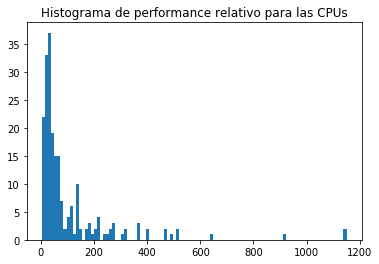

,PRP
0,0
1,1
2,1
3,0
4,0


In [13]:

# Data info
cpuData.info()
cpuData.describe(include='O')

#Copying ERP colum into a seperate dataframe
data_ERP =  cpuData[cpuData.columns[-1]]
data_ERP.head()
#Dropping ERP column
cpuData = cpuData.drop(['ERP'], axis=1)

# Separating X and labels
cpuData.reset_index(inplace=True)
x = cpuData.drop(['index','PRP'], axis=1)
y = cpuData['PRP']

plt.hist(y, bins = 100)
plt.title('Histograma de performance relativo para las CPUs')
plt.show()

# Categorizando los labels para volver un problema de clasificación. PRP = 0-350, 350-600 and 800 for lower, medium and high performanc relatively
y2 = pd.cut(y, [0, 200, 400, 1200])
#y2 = pd.cut(y, 5)
y3 = pd.DataFrame(y2)
y3["PRP"] = y3["PRP"].astype('category').cat.codes
y3.head()

In [14]:
# encoding categorical features
x["vendorName"] = x["vendorName"].astype('category').cat.codes
x["modelName"] = x["modelName"].astype('category').cat.codes

#splitting dataset in training and test
x_train, x_test, y_train, y_test = train_test_split(x, pd.DataFrame(y3), test_size=0.33, random_state=42)
x_train = np.array(x_train)
y_train = np.array(y_train)
print(x_train.shape[0], x_test.shape[0])

140 69


In [15]:
numGen = 7

model = RandomForestClassifier()
fsga = FeatureSelectionGA(model,x_train,y_train)
pop, fits, bestIndiv = fsga.generate(30, ngen = numGen)


EVOLVING.......


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: DataConversionWarning: A column-vector y was passed whe

-- GENERATION 1 --


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in 

Evaluated 18 individuals
-- GENERATION 2 --


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in 

Evaluated 18 individuals
-- GENERATION 3 --


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in 

Evaluated 18 individuals
-- GENERATION 4 --


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in 

Evaluated 16 individuals
-- GENERATION 5 --


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in 

Evaluated 18 individuals
-- GENERATION 6 --


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in 

Evaluated 12 individuals
-- GENERATION 7 --


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in 

Evaluated 18 individuals
-- Only the fittest survives --
Best individual is [0, 1, 0, 0, 0, 0, 1, 1], (0.9357142857142857,)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


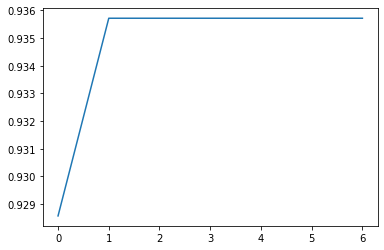

In [16]:
#Select the best individual from the final population and fit the initialized model
plt.figure()
fit=[]
for key, value in fits.items():
    fit.append(value)
plt.plot(np.array(range(numGen)), fit)
plt.show()

bestIndiv = np.array(bestIndiv)
idx = np.where(bestIndiv == 1)[0]

In [17]:
# Seleccionando las características que mejor representan el set de datos de acuerdo al algoritmo genético
x_train = pd.DataFrame(x_train)
y_train = pd.DataFrame(y_train)
x_train = x_train.iloc[:,idx]
x_test = x_test.iloc[:,idx]

model.fit(x_train,y_train)
predicted_y_train = model.predict(x_train)
print('Algunas métricas de desempeño del algoritmo para el set de entrenamiento son: \n')
print(classification_report(y_train,predicted_y_train))

predicted_y_test = model.predict(x_test)
score = f1_score(y_test,predicted_y_test, average=None)
print('Algunas métricas de desempeño del algoritmo para el set de evaluación son: \n')
print(classification_report(y_test,predicted_y_test))

Algunas métricas de desempeño del algoritmo para el set de entrenamiento son: 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       126
           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00         4

    accuracy                           1.00       140
   macro avg       1.00      1.00      1.00       140
weighted avg       1.00      1.00      1.00       140

Algunas métricas de desempeño del algoritmo para el set de evaluación son: 

              precision    recall  f1-score   support

           0       0.82      1.00      0.90        53
           1       1.00      0.20      0.33        10
           2       1.00      0.33      0.50         6

    accuracy                           0.83        69
   macro avg       0.94      0.51      0.58        69
weighted avg       0.86      0.83      0.78        69



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
